In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Overview

In the previous post, we covered the following topics:
    
- A Gaussian process (GP) defines a distribution over functions (i.e. function evaluations). √
- Marginalizing a Gaussian over a subset of its elements gives another Gaussian (just pluck out the pieces of interest). √
- Conditioning a subset of the elements of a Gaussian on another subset gives another Gaussian (a simple algebraic formula). √
- Posterior over functions (the linear map of the posterior over weights onto some matrix $A = \phi(X_{*})^T$) √
- Covariances (the second thing we need in order to specify a multivariate Gaussian) √

**Conversely, we did not directly cover:**

- Kernels
- Squared-exponentials

Here, we'll explain the latter two.

# The more features we have, the more expressive our model

We concluded the previous post by plotting posteriors over function evaluations given various `phi_func`s, i.e. a function that creates "features" $\phi(X)$ given an input $X$. For example:

```python
X_train = np.array([-3, -5, 6, 2, 1])  # 5 inputs
y_train = np.array([1, 4, 2, 9, 4])  # 5 corresponding outputs, which we'll use below

def phi_func(x):
    return np.array([3 * np.cos(x), np.abs(x - np.abs(x - 3))])  # makes d=2 features for each input
    
    
>>> phi_func(X_train).shape
(2, 5)
```

One common such set of features are those given by "radial basis functions", a.k.a. the "squared exponential" function, which we defined as:

```python
def phi_func(x, D=D):
    return np.array([np.exp(-.5 * (x - d)**2) for d in range(int(-D / 2), int(D / 2))])  # phi_x.shape: (D, len(x))
```

Again, our choice of which features to use is ultimately arbitrary, i.e. a modeling choice. 

Therein, we saw that the larger the dimensionality $D$ of our feature function, the more expressive, and/or less endemically prone to overfitting, our model becomes.

**How far can we take this?**

# Computing features is expensive

Ideally, we'd compute as many features as possible for each input element. However, the cost of doing so adds up, and ultimately becomes unrealistic past a certain number of features, i.e. dimensionality, `D`. 

**Perhaps there's a better way?**

# How are these things used?

Let's bring back our GP equations, and prepare ourselves to *squint*. In the previous post, we noted:

### Marginalizing $P(w, y)$ over $y$ gives the posterior distribution over weights, $P(w\vert y)$.

- First, the mathematical equation:

$$
\begin{align*}
P(w\vert y)
    &= \mathcal{N}(\mu_w + \Sigma_{wy}\Sigma_y^{-1}(y - \mu_y), \Sigma_w - \Sigma_{wy}\Sigma_y^{-1}\Sigma_{wy}^T)\\
    \\
    &= \mathcal{N}(\mu_w + \Sigma_{wy}(\phi(X)^T\Sigma_w \phi(X))^{-1}(y - \mu_w^T \phi(X)), \Sigma_w - \Sigma_{wy}(\phi(X)^T\Sigma_w \phi(X))^{-1}\Sigma_{wy}^T)
\end{align*}
$$

- Next, this equation in code:

```python
# Define initial parameters
D = ...  # dimensionality of our feature function

mu_w = np.zeros(D)  # often a vector of zeros, though it doesn't have to be
cov_w = np.eye(D)  # often the identity matrix, though it doesn't have to be

# Featurize `X_train`
phi_x = phi_func(X_train)

# Params of prior distribution over function evals
mu_y = phi_x.T @ mu_w
     = np.zeros(D)
cov_y = phi_x.T @ cov_w @ phi_x

# Params of posterior distribution over weights
mu_w_post = mu_w + cov_w @ phi_x @ np.linalg.inv(cov_y) @ (y_train - mu_y)
          = mu_w + cov_w @ phi_x @ np.linalg.inv(cov_y) @ y_train
cov_w_post = cov_w - cov_w @ phi_x @ np.linalg.inv(cov_y) @ phi_x.T @ cov_w
```

### The linear map of $P(w\vert y)$ onto some matrix $\phi(X_*)^T$ gives the posterior distribution over function evaluations, $P(y_*\ \vert\ y)$.

Here, $X_*$ is a set of test points, e.g. `np.array([17, 52, -12])`, and $P(y_*\ \vert\ y) = P(\phi(X_{*})^Tw\ \vert\ y)$.

For readability, let's call $X_* \rightarrow$ `X_test` and $y_* \rightarrow$ `y_test`.

- The mathematical equations in code:

```python
# Featurize `X_test`
phi_x_test = phi_func(X_test)

# The following two equations were defined above
mu_w_post = mu_w + cov_w @ phi_x @ np.linalg.inv(cov_y) @ y_train
          = cov_w @ phi_x @ np.linalg.inv(phi_x.T @ cov_w @ phi_x) @ y_train
          
cov_w_post = cov_w - cov_w @ phi_x @ np.linalg.inv(cov_y) @ phi_x.T @ cov_w
           = cov_w - cov_w @ phi_x @ np.linalg.inv(phi_x.T @ cov_w @ phi_x) @ phi_x.T @ cov_w

# The mean of the posterior distribution over function evaluations
mu_y_test_post = phi_x_test.T @ mu_w_post
               = phi_x_test.T @ cov_w @ phi_x @ np.linalg.inv(phi_x.T @ cov_w @ phi_x) @ y_train

# The covariance of the posterior distribution over function evaluations
cov_y_test_post = phi_x_test.T @ cov_w_post @ phi_x_test
                = phi_x_test.T @ (cov_w) @ phi_x_test - \
                  phi_x_test.T @ (cov_w @ phi_x @ np.linalg.inv(phi_x.T @ cov_w @ phi_x) @ \
                  phi_x.T @ cov_w) @ phi_x_test
```

**NB: If any of this felt foreign, please look no further, and re-visit the [previous post]().**

# Never alone

Squinting at the equations for `mu_y_test_post` and `cov_y_test_post`, we see that `phi_x` and `phi_x_test` appear **only in the presence of another `phi_x`, or `phi_x_test`.** 

The four distinct such terms are:

```python
phi_x_test.T @ cov_w @ phi_x_test
phi_x_test.T @ cov_w @ phi_x
phi_x.T @ cov_w @ phi_x
phi_x.T @ cov_w @ phi_x_test
```

In mathematical notation, they are (respectively):

- $\phi(X_*)^T\Sigma_w \phi(X_*)$
- $\phi(X_*)^T\Sigma_w \phi(X)$
- $\phi(X)^T\Sigma_w \phi(X)$
- $\phi(X)^T\Sigma_w \phi(X_*)$

# Simplifying further

These are nothing more than *scaled* (via the $\Sigma_w$ term) dot products in some expanded feature space $\phi$. 

*Until now, we've explicitly chosen what this $\phi$ function is.*

If the scaling matrix $\Sigma_w$ is [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix), we can state the following, using $\phi(X)^T\Sigma_w \phi(X)$, i.e. `phi_x.T @ cov_w @ phi_x`, as an example:

$$
\begin{align*}
\Sigma_w = (\sqrt{\Sigma_w})^2
\end{align*}
$$

$$
\begin{align*}
\phi(X)^T \Sigma_w \phi(X) 
    &= \big(\sqrt{\Sigma_w}\phi(X)\big)^T\big(\sqrt{\Sigma_w}\phi(X)\big)\\
    &= \varphi(X)^T\varphi(X)\\
    &= \varphi(X) \cdot \varphi(X)\\
\end{align*}
$$

As such, our four distinct scaled-dot-product terms can be rewritten as:

- $\phi(X_*)^T\Sigma_w \phi(X_*) = \varphi(X_*) \cdot \varphi(X_*)$
- $\phi(X_*)^T\Sigma_w \phi(X) = \varphi(X_*) \cdot \varphi(X)$
- $\phi(X)^T\Sigma_w \phi(X) = \varphi(X) \cdot \varphi(X)$
- $\phi(X)^T\Sigma_w \phi(X_*) = \varphi(X) \cdot \varphi(X_*)$

**In other words, our scaled-dot-product terms can be equivalently written as dot-products in some space $\varphi$.** 

*We have **not** explicitly chosen what this $\varphi$ function is.*

# Kernels

A "kernel" is a function which gives the similarity between individual elements in two sets, i.e. a Gram matrix.

For instance, imagine we have two sets of countries, $\{\text{France}, \text{Germany}, \text{Iceland}\}$ and $\{\text{Morocco}, \text{Denmark}\}$, and that similarity is given by an integer value in $[1, 5]$, where 1 is the least similar, and 5 is the most. Applying a kernel to these sets gives a Gram matrix such as:

In [2]:
import pandas as pd

pd.DataFrame([[4, 2, 1], [3, 3, 4]], columns=['France', 'Germany', 'Iceland'], index=['Morocco', 'Denmark'])

,France,Germany,Iceland
Morocco,4,2,1
Denmark,3,3,4


**When you hear the term "kernel" in the context of machine learning, think "similarity between things in lists." That's it.**

(A "list" could be a list of vectors, which is a matrix. A vector, or a matrix, are the canonical inputs to a kernel.)

# Mercer's Theorem

Mercer's Theorem has as a key result that any kernel function can be expressed as a dot product, i.e.

$$
K(X, X') = \varphi(X) \cdot \varphi (X')
$$

where $\varphi$ is some function which maps the original input into some "expanded", i.e. "featurized", space $\mathbb{R}^D$.

## Example

To illustrate, I'll borrow an example from [CrossValidated](https://stats.stackexchange.com/questions/152897/how-to-intuitively-explain-what-a-kernel-is):


"For example, consider a simple polynomial kernel $k(\mathbf x, \mathbf y) = (1 + \mathbf x^T \mathbf y)^2$ with $\mathbf x, \mathbf y \in \mathbb R^2$. This doesn't seem to correspond to any mapping function $\varphi$, it's just a function that returns a real number. Assuming that $\mathbf x = (x_1, x_2)$ and $\mathbf y = (y_1, y_2)$, let's expand this expression:

$$
\begin{align}
k(\mathbf x, \mathbf y) 
    &= (1 + \mathbf x^T \mathbf y)^2\\
    &= (1 + x_1 \, y_1  + x_2 \, y_2)^2\\
    &= 1 + x_1^2 y_1^2 + x_2^2 y_2^2 + 2 x_1 y_1 + 2 x_2 y_2 + 2 x_1 x_2 y_1 y_2
\end{align}
$$

Note that this is nothing else but a dot product between two vectors $(1, x_1^2, x_2^2, \sqrt{2} x_1, \sqrt{2} x_2, \sqrt{2} x_1 x_2)$ and $(1, y_1^2, y_2^2, \sqrt{2} y_1, \sqrt{2} y_2, \sqrt{2} y_1 y_2)$, and $\varphi(\mathbf x) = \varphi(x_1, x_2) = (1, x_1^2, x_2^2, \sqrt{2} x_1, \sqrt{2} x_2, \sqrt{2} x_1 x_2)$. So the kernel $k(\mathbf x, \mathbf y) = (1 + \mathbf x^T \mathbf y)^2 = \varphi(\mathbf x) \cdot \varphi(\mathbf y)$ computes a dot product in 6-dimensional space without explicitly visiting this space."

## What this means

![](./kernels-for-gaussian-processes.svg)

- We start with inputs $X$ and $Y$.
- Our goal is to compute the similarity between then, $\text{Sim}(X, Y)$.

### Bottom path
- Lifting these inputs into some feature space, then computing their dot-product in that space, i.e. $\varphi(X) \cdot \varphi (Y)$, is one strategy for computing this similarity.
- Unfortunately, this robustness comes at a cost: **this computation is extremely expensive.**

### Top Path
- A valid kernel (function) computes similarity between inputs. The function it employs might be extremely simple, e.g. $(X - Y)^{123}$; **this computation is extremely cheap.**

### Mercer!
- Mercer's Theorem tells us that this valid kernel, i.e. the top path, is implicitly traversing the bottom path. **In other words, kernels allow us to directly compute the result of an extremely expensive computation, extremely cheaply.**

# How does this help?

Once more, the Gaussian process equations are littered with the following terms:

- $\phi(X_*)^T\Sigma_w \phi(X_*) = \varphi(X_*) \cdot \varphi(X_*)$
- $\phi(X_*)^T\Sigma_w \phi(X) = \varphi(X_*) \cdot \varphi(X)$
- $\phi(X)^T\Sigma_w \phi(X) = \varphi(X) \cdot \varphi(X)$
- $\phi(X)^T\Sigma_w \phi(X_*) = \varphi(X) \cdot \varphi(X_*)$

Furthemore, we established previously that the more we increase the dimensionality $D$ of these feature functions $\varphi$, the more flexible our models become.

Unfortunately, and irrespective of what $\varphi$ actually is, this computation becomes **extremely expensive to compute.**

## Kernels!

You know where this is going.

Given Mercer's theorem, we can state the following equalities:

- $\varphi(X_*) \cdot \varphi(X_*) = K(X_*, X_*)$
- $\varphi(X_*) \cdot \varphi(X) = K(X_*, X)$
- $\varphi(X) \cdot \varphi(X) = K(X, X)$
- $\varphi(X) \cdot \varphi(X_*) = K(X, X_*)$

# Which kernels to choose?

At the outset, we stated that our primary goal was to increase $D$. As such, **let's pick the kernel whose implicit $\varphi$ has the largest dimensionality possible.**

In the example above, we saw that the kernel $k(\mathbf x, \mathbf y)$ was implicitly computing a $D=6$-dimensional dot-product. Which kernels compute a $D=100$-dimensional dot-product? $D=1000$?

**How about $D=\infty$?**

# Radial basis functions, a.k.a. the "squared-exponential"

This kernel is implicitly computing a $D=\infty$-dimensional dot-product. That's it. **That's why it's so ubiquitous in Gaussian processes.**

# Rewriting our equations

With all of the above in mind, let's rewrite the equations for the parameters of our posterior distribution over function evaluations.

```python
# The mean of the posterior distribution over function evaluations
mu_y_test_post = phi_x_test.T @ mu_w_post
               = phi_x_test.T @ cov_w @ phi_x @ np.linalg.inv(phi_x.T @ cov_w @ phi_x) @ y_train
               
               # Now, substituting in our kernels
               = k(X_test, X_train) @ np.linalg.inv(k(X_train, X_train)) @ y_train

# The covariance of the posterior distribution over function evaluations
cov_y_test_post = phi_x_test.T @ cov_w_post @ phi_x_test
                = phi_x_test.T @ cov_w @ phi_x_test - \
                  phi_x_test.T @ cov_w @ phi_x @ np.linalg.inv(phi_x.T @ cov_w @ phi_x) @ \
                  phi_x.T @ cov_w @ phi_x_test
                  
                # Now, substituting in our kernels
                = k(X_test, X_test) - \
                  k(X_test, X_train) @ np.linalg.inv(k(X_train, X_train)) @ k(X_train, X_test)
```

# Defining the kernel in code

Mathematically, the RBF kernel is defined as follows:

$$
K(X, Y) = \exp(-\frac{1}{2}\vert X - Y \vert ^2)
$$

Finally, let's define a Python function for the parameters of our posterior over function evaluations, using this RBF kernel as `k`.

In [13]:
X_train = np.array([-3, -5, 6, 2, 1])  # 5 inputs
y_train = np.array([1, 4, 2, 9, 4])  # 5 corresponding outputs, which we'll use below
X_test = np.array([8, 3, 4])  # vector of test inputs


def rbf_kernel(x, y):
    x = np.expand_dims(x, 1)  # dims: (len(x), 1)
    y = np.expand_dims(y, 0)  # dims: (1, len(y))
    # x - y --> dims: (len(x), len(y))
    return np.exp(-.5 * (x - y)**2)


def k(x, y):
    return rbf_kernel(x, y)
    

# The following quantity is used in both `mu_y_test_post` and `cov_y_test_post`; 
# we extract it into a separate variable for readability
A = k(X_test, X_train) @ np.linalg.inv(k(X_train, X_train))

mu_y_test_post = A @ y_train            
cov_y_test_post = k(X_test, X_test) - A @ k(X_train, X_test)

# Plot results

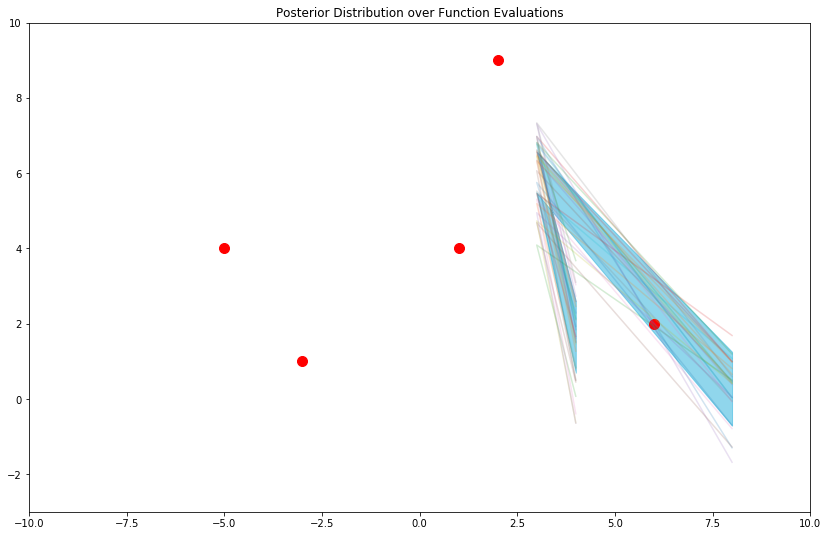

In [14]:
def plot_gp_posterior(mu_y_post, cov_y_post, x_train, y_train, x_test, n_samples=0, ylim=(-3, 10)):
    plt.figure(figsize=(14, 9))
    plt.ylim(*ylim)
    plt.xlim(-10, 10)
    plt.title('Posterior Distribution over Function Evaluations')

    # Extract the variances, i.e. the diagonal, of our covariance matrix
    var_y_post = np.diag(cov_y_post)

    # Plot the error bars.
    # To do this, we fill the space between `(mu_y_post - var_y_post, mu_y_post + var_y_post)` for each `x`
    plt.fill_between(x_test, mu_y_post - var_y_post, mu_y_post + var_y_post, color='#23AEDB', alpha=.5)

    # Scatter-plot our original 6 `(x, y)` tuples
    plt.plot(x_train, y_train, 'ro', markersize=10)

    # Optionally plot actual samples (function evaluations) from this posterior
    if n_samples > 0:
        for _ in range(n_samples):
            y_pred = np.random.multivariate_normal(mu_y_post, cov_y_post)
            plt.plot(x_test, y_pred, alpha=.2)


plot_gp_posterior(mu_y_test_post, cov_y_test_post, X_train, y_train, X_test, n_samples=25)

# Infinite features, implicitly

# things to do
- draw a diagram showing what the kerne trick does, i.e. circumvents the "explicitly map elements of a set into some expanded space"
- what is a gram matrix?
- really, what is a covariance function...

In [1]:
import numpy as np

In [3]:
a = np.array([1, 2, 3])
b = np.array([3, 4, 5])

# infinite features?

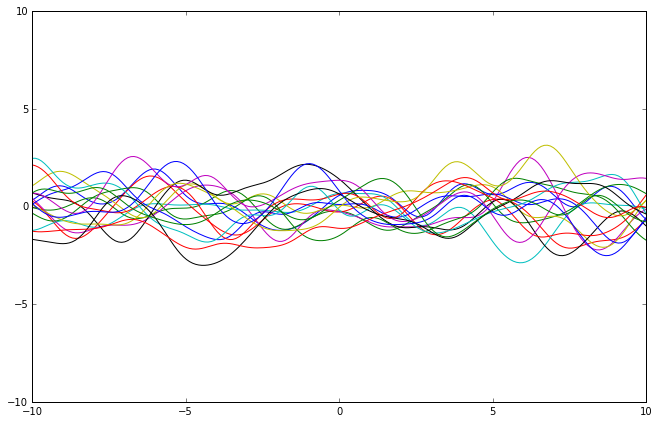

In [21]:
def rbf(a, b, c=1, l=1):
    a = np.expand_dims(a, 1)  # dims: (len(x), 1)
    b = np.expand_dims(b, 0)  # dims: (1, len(b))
    # a - b --> dims: (len(x), len(b))
    return np.exp(c * -.5 * ((a - b) / l)**2)


# mu_w : a vector with an infinite number of 0's
# cov_w : a square matrix with sides of infinite length

x = np.linspace(-10, 10, 200)

mu_lc = np.zeros_like(x)
cov_lc = rbf(x, x)

plt.figure(figsize=(11, 7))
plt.ylim(-10, 10)
plt.xlim(-10, 10)

for _ in range(17):
    lc = np.random.multivariate_normal(mu_lc, cov_lc)
    plt.plot(x, lc)

In [22]:
# analytical posterior, with kernels

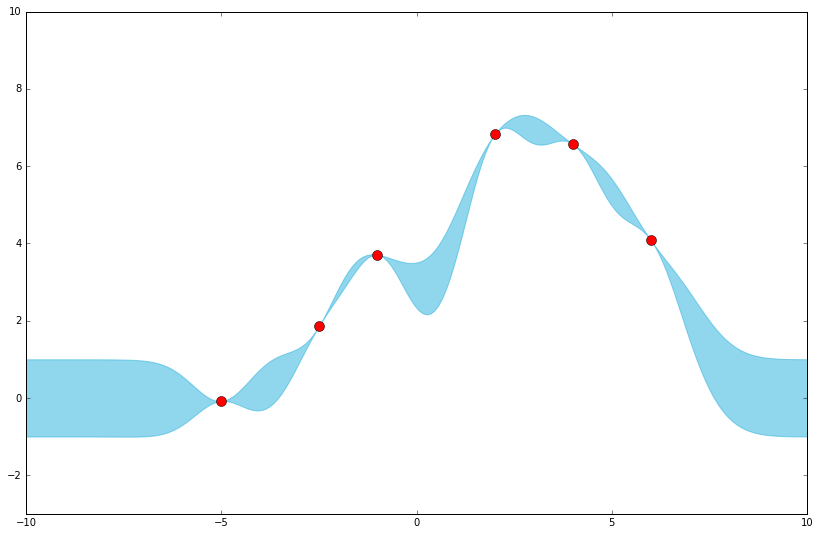

In [23]:
# Update prior over weights, then prior over function evals, with observed data
cov_obs = 0 * \
    np.eye(len(x_train))

A = rbf(x_test, x_train) @ np.linalg.inv(rbf(x_train, x_train) + cov_obs)
mu_y_post  = A @ y_train
cov_y_post = rbf(x_test, x_test) - A @ rbf(x_train, x_test)

# Plot
plot_gp_posterior(mu_y_post, cov_y_post, x_train, y_train, x_test)

# This whole covariance business

In [24]:
# D = 7
# N_OBS = 12

# mu_w = np.random.randn(D)

# 1. we can just make this ourselves:
#    - how does each of the 7 dimensions covary with every other dimension?
#    - for this reason, the thing will always be of size 7 x 7
# 2. we can estimate this from data
#    - numpy docs say: "m : array_like; A 1-D or 2-D array containing multiple variables 
#      and observations. Each row of m represents a variable, and each column a single 
#      observation of all those variables."
#    - this is backwards from what we typically think. nonetheless, our input to np.cov
#      should be of size (D, N_OBS)

# cov_w = np.cov(np.random.randn(D, N_OBS))

# N_OBS_X = 100

# mu_y = np.random.randn(N_OBS_X)  # after passing it through the mean function, which collapses the dimensionality D to 1
# phi_x = np.random.randn(D, N_OBS_X)  # same as above, with D first then N_OBS_X
# cov_y = phi_x.T @ cov_w @ phi_x  # 100 x 100; # we often just compute this directly with RBF kernel; this is the explicit way, which is of course infeasible if `phi` gives inf features!

# # now pluck out your things
# cov_w_y = cov_w @ phi_x  # (7 x 7) @ (7, 100) --> 7, 100
# cov_y_x = phi_x.T @ cov_w  # (100 x 7) @ (7, 7) --> 100, 7

"Centering the process on a linear model, while allowing the process to accommodate deviations from the lienar model, addresses the curse of dimensionality, as the psoterior can concentrate close to the linear moel (or an alternative parametric mean function) to an extent supported by the data"

BDA3, Chapter 21

# $P(y^{*}\vert y)$

(just multiply phi(x_new) through the mean, and wrapped around the covariance)